In [1]:
%run Reddit_import_and_functions.ipynb

## Managing HDF5 Large Datasets and Partitioning

In [3]:
headers = pd.read_csv('masterFeaturesVector.csv')

Train1allinfo = pd.read_csv("Train1allinfo.csv")
Train1allinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440145 entries, 0 to 440144
Data columns (total 7 columns):
Unnamed: 0    440145 non-null int64
index         440145 non-null int64
datetime      440145 non-null float64
corpus        440145 non-null object
permalink     440145 non-null object
author        440145 non-null object
subreddit     440145 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 23.5+ MB


In [8]:
Train1allinfo = pd.read_csv("Train1allinfo.csv")

envmask = Train1allinfo['subreddit'].astype(bool)
cryptomask = 1 - envmask
cryptomask = cryptomask.astype(bool)
print(cryptomask.sum())
envmask.sum()

293358


146787

In [9]:
print(Train1allinfo[envmask].index)

Int64Index([     0,      3,      8,     17,     19,     30,     31,     34,
                39,     50,
            ...
            440119, 440120, 440121, 440127, 440131, 440135, 440136, 440137,
            440140, 440143],
           dtype='int64', length=146787)


In [3]:
with h5py.File("masterdata.hdf5",'r') as f :
    dset = f['Train1dset']
    print(dset.shape)

(440145, 17847)


### Creating Only Environment and Only Crypto HDF5 Datasets

In [3]:
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['columnsums/columnindextodrop']
    columnindextodrop = dset[:]
    print(columnindextodrop)

[    1     2     3 ... 17843 17845 17846]


In [4]:
keepcols = set(range(17847)).symmetric_difference(columnindextodrop)
len(keepcols)
keepcols = list(keepcols)

In [5]:
with h5py.File("masterdata.hdf5",'r') as f :
    dset = f['Train1dset']    
    print(dset.shape)
    df = pd.DataFrame(dset[0:440145,keepcols], dtype='int16')
    print(df.shape)
# Can only load half of rows in without memory error, when also loading all rows
# still 5.6 GB in memory now with only half of data, 1st operating on 0:220073 and saving to csv
# Did same operations/functions on 220073:440145 and appending onto those 2 csv files

(440145, 17847)
(440145, 10584)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440145 entries, 0 to 440144
Columns: 10584 entries, 0 to 10583
dtypes: int16(10584)
memory usage: 8.7 GB


In [7]:
# pruning out main dataframe rows which have 0 or 1 words in the new > 0.02% term frequency threshold
rowsumsNoRareWords = df.T.sum()
rowsumsNoRareWords.tail()

440140    12
440141    15
440142    10
440143     4
440144    61
dtype: int64

In [18]:
spamCategory = rowsumsNoRareWords.loc[lambda x : x < 5].index
print(rowsumsNoRareWords.shape)
len(spamCategory)
rowsumsNoRareWords.name = 'newwordcount'

(440145,)


In [19]:
print(df.shape)
df = df.join(rowsumsNoRareWords, how='inner')
df.shape

(440145, 10584)


(440145, 10585)

In [24]:
df.to_csv('Train1Manageable.csv', compression='gzip')

In [24]:
# Assumes df and mask have default range indexes, 0 to length, step of 1
def partitionswritetohdf5(df, mask, partitions, h5pyFile, filegroup, newdsetname) :
    rowtotal = df.shape[0]
    mask = mask.reset_index(drop=True)
    startindex = 0
    endindex = startindex + int(rowtotal/partitions)
    with h5py.File(h5pyFile,'a') as f :
        group = f[filegroup]
        try :
            dset = group[newdsetname]
            filteredindex = dset.shape[0]
            dset.resize(dset.shape[0]+mask.sum(), axis=0)
            print(df[startindex:endindex].index, mask[startindex:endindex].index)
        except :
            dset = group.create_dataset(newdsetname, dtype='i2', shape=(mask.sum(),df.shape[1]), 
                                        maxshape=(None,None), compression="lzf", shuffle=True)
            filteredindex = 0
        
        for i in range(0,partitions) :
#             print(df[startindex:endindex].index, mask[startindex:endindex].index)
            writedf = df[startindex:endindex][mask[startindex:endindex]]
            filteredendindex = filteredindex + writedf.shape[0]
            print(filteredindex,filteredendindex, writedf.shape[0])
            dset[filteredindex:filteredendindex,:] = writedf
            filteredindex = filteredendindex
            startindex = endindex
            endindex += int(rowtotal/partitions)
            if i == (partitions-2) :
                endindex = rowtotal


In [32]:
partitionswritetohdf5(df, envmask[220073:440145], 10, "masterdata.hdf5", 'rowsums', 'env_dset')
# 1st half of all rows: 0:220073
# 2nd half of all rows: 220073:440145

RangeIndex(start=0, stop=22007, step=1) RangeIndex(start=0, stop=22007, step=1)
73463 80718 7255
80718 88110 7392
88110 95470 7360
95470 102810 7340
102810 110037 7227
110037 117296 7259
117296 124554 7258
124554 131926 7372
131926 139336 7410
139336 146787 7451


In [33]:
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['rowsums/env_dset']
    print(dset.shape)
#     del f['rowsums/crypto_dset1']   

(146787, 17847)


In [25]:
envmask.sum()

146787

In [29]:
list_all_hdf5('masterdata.hdf5')

Train1dset
columnsums
columnsums/columnsumshalf0
columnsums/columnsumshalf1
environment
rowsums
rowsums/crypto_dset
rowsums/env_dset
rowsums/rowsumshalf0
rowsums/rowsumshalf1


In [35]:
testmask = envmask[110036:220073]  # need to reset index so mask matches with offset df
dftest =df[0:11003][testmask.reset_index(drop=True)[0:11003]]
dftest = None

## Primary EDA: Environment vs Cryptocurrency Subreddits

In [11]:
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['rowsums/env_dset']
    df = pd.DataFrame(data=dset[:,:], dtype='int16', 
                      columns=headers, index=Train1allinfo[envmask].index)
    print(df.shape)

(146787, 17847)


In [4]:
Train1allinfo = None

In [12]:
with h5py.File("masterdata.hdf5",'a') as f :
    r = f['rowsums']
    dset = r.create_dataset('rowsumsEnv', data=df.T.sum())
    print(dset.shape)
    dset = r.create_dataset('columnsumsEnv', data=df.sum())
    print(dset.shape)

(146787,)
(17847,)


In [15]:
with h5py.File("masterdata.hdf5",'a') as f :
    rowsumsEnv = f['rowsums/rowsumsEnv']
    rowsumsEnv = pd.Series(rowsumsEnv)
    print(rowsumsEnv.value_counts(ascending=False))

14      9107
13      8920
15      8769
12      8616
16      8112
11      7857
17      7549
10      7097
18      6456
9       6075
19      5787
8       5098
20      4883
21      4349
7       3922
22      3730
23      3325
6       3196
24      2866
25      2702
26      2481
27      2357
28      2175
5       2162
29      1907
30      1837
4       1637
31      1630
32      1444
33      1212
34      1024
3        968
35       889
36       710
2        579
37       539
38       459
39       345
40       268
1        227
42       172
41       172
43       147
0        132
44        99
47        84
45        81
46        77
53        64
48        58
52        56
57        56
51        53
49        49
55        46
54        44
58        44
56        43
67        42
59        42
62        41
61        39
50        39
64        37
60        36
69        33
65        33
68        33
70        32
63        32
66        31
73        30
74        28
87        26
77        25
75        25
71        24

In [90]:
with h5py.File("masterdata.hdf5",'a') as f :
    columnsumsEnv = f['rowsums/columnsumsEnv']
    columnsumsEnv = pd.Series(columnsumsEnv) #, index=headers)
    #print(columnsumsEnv.sort_values(ascending=False))
    

In [18]:
columnsumsEnv.sort_values(ascending=False).to_csv('env_freqwords.csv')

In [5]:
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['rowsums/crypto_dset']
    df = pd.DataFrame(data=dset[:,:], dtype='int16', 
                      index=cryptomask[cryptomask].index)
    print(df.shape)

(293358, 17847)


In [6]:
with h5py.File("masterdata.hdf5",'a') as f :
    r = f['rowsums']
    dset = r.create_dataset('rowsumsCrypto', data=df.T.sum())
    print(dset.shape)
    dset = r.create_dataset('columnsumsCrypto', data=df.sum())
    print(dset.shape)

(293358,)
(17847,)


In [91]:
with h5py.File("masterdata.hdf5",'a') as f :
    columnsumsCrypto = f['rowsums/columnsumsCrypto']
    columnsumsCrypto = pd.Series(columnsumsCrypto) #, index=headers)
    #print(columnsumsCrypto.sort_values(ascending=False))
    

In [5]:
columnsumsCrypto.sort_values(ascending=False).to_csv('crypto_freqwords.csv')

In [92]:
cryptoWords10plusPerc = columnsumsCrypto.map(lambda x : x / 293358).loc[lambda x : x > 0.01]
envWords10plusPerc = columnsumsEnv.map(lambda x : x / 146787).loc[lambda x : x > 0.01]
cryptoWords10plusPerc.name = 'cryptowords'
cryptoWords10plusPerc.head()

22     0.016447
70     0.012906
76     0.012197
93     0.037562
160    0.018343
Name: cryptowords, dtype: float64

In [93]:
envWords10plusPerc = pd.DataFrame(envWords10plusPerc)
envWords10plusPerc.columns = ['envwords']

In [26]:
commonWords10plusPerc = envWords10plusPerc.join(cryptoWords10plusPerc, how='inner')
commonWords10plusPerc

,wordcount,cryptowords
"(874, article)",0.106924,0.026817
"(1185, bad)",0.026406,0.016877
"(1232, ban)",0.027462,0.017559
"(1489, best)",0.011779,0.051060
"(1528, big)",0.040658,0.047498
"(1839, blog)",0.056327,0.024762
"(2047, break)",0.010961,0.011287
"(2264, business)",0.029982,0.026442
"(2352, call)",0.014191,0.015043
"(2485, case)",0.010348,0.017559


In [27]:
commonWords10plusPerc.to_csv('commonWords1plusPerc.csv')

In [28]:
commonWords10plusPerc.sort_values('cryptowords',ascending=False)

,wordcount,cryptowords
"(10818, new)",0.111202,0.134321
"(10835, news)",0.212553,0.124905
"(7539, have)",0.068896,0.122557
"(16805, use)",0.053240,0.116380
"(8924, just)",0.038791,0.113622
"(12432, price)",0.010812,0.094652
"(10035, medium)",0.014313,0.090388
"(15950, time)",0.044759,0.083366
"(11824, people)",0.042817,0.081695
"(9768, make)",0.045270,0.077547


In [94]:
# 1 in 5000 posts rare words will be excluded for first model
cryptoRareWords = columnsumsCrypto.map(lambda x : x / 293358).loc[lambda x : x < 0.0002]
envRareWords = columnsumsEnv.map(lambda x : x / 146787).loc[lambda x : x < 0.0002]
cryptoRareWords.name = 'cryptowords'
envRareWords = pd.DataFrame(envRareWords)
envRareWords.columns = ['envwords']

In [95]:
commonRareWords = envRareWords.join(cryptoRareWords, how='inner')
commonRareWords.tail()

,envwords,cryptowords
17838,0.000000,0.000085
17839,0.000000,0.000112
17843,0.000075,0.000187
17845,0.000007,0.000055
17846,0.000000,0.000061


In [97]:
columnindextodrop = commonRareWords.index
columnindextodrop.shape
with h5py.File("masterdata.hdf5",'a') as f :
    group = f['columnsums']
    group.create_dataset('columnindextodrop', data=columnindextodrop)

In [99]:
list_all_hdf5("masterdata.hdf5")

Train1dset
columnsums
columnsums/columnindextodrop
columnsums/columnsumshalf0
columnsums/columnsumshalf1
environment
rowsums
rowsums/columnsumsCrypto
rowsums/columnsumsEnv
rowsums/crypto_dset
rowsums/env_dset
rowsums/rowsumsCrypto
rowsums/rowsumsEnv
rowsums/rowsumshalf0
rowsums/rowsumshalf1


In [89]:
commonRareWords.sort_values('cryptowords',ascending=False).to_csv('commonRareWords.csv')

In [84]:
commonRareWords.sort_values('cryptowords',ascending=False)

,envwords,cryptowords
"(760, applicant)",0.000048,0.000198
"(3176, cointrust)",0.000007,0.000198
"(1050, aurora)",0.000068,0.000198
"(9705, macd)",0.000000,0.000198
"(980, aths)",0.000000,0.000198
"(15119, stressful)",0.000027,0.000198
"(12026, piper)",0.000034,0.000198
"(4409, decrypt)",0.000000,0.000198
"(8335, inferno)",0.000102,0.000198
"(12396, presearch)",0.000000,0.000198


## Empty Posts, with no Lemma, Other Posts to Exclude

In [52]:
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['rowsums/rowsumsEnv']
    rowsumsEnv = pd.Series(data=dset, index=envmask[envmask].index, name='envWords')
    emptypostsEnv = rowsumsEnv.loc[lambda x : x==0]

In [53]:
Train1allinfo.loc[emptypostsEnv.index,['corpus']].values

array([[' atıklarımı neden lisanslı geri dönüşüm firmalarına vermeliyim atiksahasi atiklarimi neden lisansli geri donusum firmalarina vermeliyim'],
       [' repreve jov repreve'],
       ['  '],
       [' jpea jpea'],
       [' haveaffald haveaffald'],
       ['  kannada savyasaachi'],
       [' jokesms jokesms'],
       [' waterclean techindo waterclean techindo'],
       [' берегите воду или как экономить воду vodamama ekonomim vodu'],
       [' rejs sverige hannaswalk rejs sverige'],
       [' reciclez faci stiridebine reciclez faci'],
       [' supertits latina kiara mia cliphunter supertitslatinakiaramia'],
       [' anders bekeken stichtingmilieunet andersbekekenblog'],
       ['  thehomemortgagegroup'],
       [' radon radonmåling hvordan måler radon miljolab miljolab'],
       [' backgammon regeln backgammonregelnlernen'],
       [' mni wiconi fyufo mni wiconi'],
       [' tjäna pengar kabelåtervinning lantzmetall tjanster vad atervinner kabel'],
       [' centrali carbone qua

In [40]:
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['rowsums/rowsumsCrypto']
    rowsumsCrypto = pd.Series(data=dset, index=cryptomask[cryptomask].index, name='cryptoWords')
    emptypostsCrypto = rowsumsCrypto.loc[lambda x : x==0]

In [51]:
Train1allinfo.loc[emptypostsCrypto.index,['corpus']].values

array([[' ndndhdhdh ndndhdhdh'],
       ['  ggc'],
       [' cryptopiece cryptopiece'],
       [' cryptotalk cryptotalk'],
       [' molikcoin molikcoin imweb'],
       [' bibitbot bibitbot'],
       [' cryptocoinsjar cryptocoinsjar'],
       [' cointiply cointiply'],
       [' gokucoin gokucoin'],
       [' hammercoin hammercoin'],
       [' cryptokami cryptokami cqln cryptokami'],
       [' blkcf xdur blkcf'],
       [' jdhdhfhjdjfhf jdhdhfhjdjfhf'],
       [' lendconnect ttwib lendconnect'],
       [' prtfolio prtfolio'],
       [' reecoin reecoin'],
       [' headdddd steeeeeammmming headdddd steeeeeammmming'],
       [' cryptoshirt woppal cryptoshirt woppal'],
       ['  qfhnk'],
       [' hahahahahahahahaha ljxct hahahahahahahahaha'],
       ['   '],
       ['  ethonline'],
       [' cryptobasesignals cryptobasesignals'],
       [' electroncash checksum electroncash checksum'],
       [' ultc ultc'],
       ['  tyxso'],
       [' btcsmash btcsmash'],
       ['  peszg'],
       ['

In [54]:
emptypostscount = Train1allinfo.loc[emptypostsCrypto.index,['corpus']].shape[0] + Train1allinfo.loc[emptypostsEnv.index,['corpus']].shape[0]
emptypostscount

290

In [60]:
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['rowsums/rowsumsEnv']
    rowsumsEnv = pd.Series(data=dset, index=envmask[envmask].index, name='envWords')
    posts1wordEnv = rowsumsEnv.loc[lambda x : x==1]
Train1allinfo.loc[posts1wordEnv.index,['corpus']].values

array([[' erreplast eccellenza nel campo del riciclo nel cuore della campania rinnovabili dettaglio comunicato stampa erreplast eccellenza campana targata conai'],
       [' کمک زلزله زدگان کرمانشاه redd ieu'],
       [' naturalis nuova rivista cultura ambientale edita ardea educareallambienteallanatura wordpress naturalis nuova rivista cultura ambientale edita ardea'],
       [' drop everylastdrop'],
       [' plasticarian sustainablebusinesstoolkit plasticarian'],
       [' janique madison clipmarks clipmark'],
       [' sittes konténer rendelés budapesten építkezésekhez sittszallitas kontenerrendeles net sittes kontener'],
       ['  quickmeme meme gese'],
       [' abtrans entsorgung hannover abtrans entsorgung haushaltsaufloesungen'],
       [' revelatory naturalism aglobalpublicservant net revelatory naturalism'],
       [' stopplasticstraws instragram instagram blcgw uggzi'],
       [' حظك اليوم الثلاثاء توقعات ابراج اليوم اغسطس mediashow blogspot'],
       [' spagna risparmiera

In [69]:
# 95% of one word posts for just Crypto are 'remove' posts with otherwise only non-lemma words
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['rowsums/rowsumsCrypto']
    rowsumsCrypto = pd.Series(data=dset, index=cryptomask[cryptomask].index, name='cryptoWords')
    posts1wordCrypto = rowsumsCrypto.loc[lambda x : x==1]

In [68]:
print(Train1allinfo.loc[posts1wordCrypto.index,['corpus','permalink']].values[50:100])

[[' xbi remove fgchi xbincognito xbi bitexbaycom'
  'https://www.reddit.com/r/CryptoCurrency/comments/9fgchi/xbincognito_xbi_bitexbaycom/']
 [' dogeminer remove inkyf dogeminer'
  'https://www.reddit.com/r/CryptoCurrency/comments/8inkyf/dogeminer/']
 [' investment do ytcropper cropped'
  'https://www.reddit.com/r/CryptoCurrency/comments/82eu0z/how_are_your_investments_doing/']
 [' workcoin remove mgt workcoin'
  'https://www.reddit.com/r/CryptoCurrency/comments/8e6mgt/workcoin/']
 [' crtk remove crtk'
  'https://www.reddit.com/r/CryptoCurrency/comments/8am4yz/перспективные_токены_crtk/']
 [' handy cryptocurrencyalerting'
  'https://www.reddit.com/r/CryptoCurrency/comments/8nnuv3/this_is_handy/']
 ['  imgur otgivrz'
  'https://www.reddit.com/r/CryptoCurrency/comments/80r1ta/but_they_could_be_now/']
 [' scicoins remove ifa scicoins'
  'https://www.reddit.com/r/CryptoCurrency/comments/881ifa/scicoins/']
 [' petros hombre imgur yzctrh'
  'https://www.reddit.com/r/CryptoCurrency/comments/85

In [71]:
print(posts1wordEnv.shape)
print(posts1wordCrypto.shape)

(227,)
(1298,)


In [70]:
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['rowsums/rowsumsEnv']
    rowsumsEnv = pd.Series(data=dset, index=envmask[envmask].index, name='envWords')
    posts2wordEnv = rowsumsEnv.loc[lambda x : x==2]
Train1allinfo.loc[posts2wordEnv.index,['corpus']].values

array([[' portugal yurt retreat portugalyurtretreat'],
       [' alkaline booster alkazone'],
       [' bioalquimia rejeito industrial vira água limpa ehelpcarolina bioalquimia rejeito industrial vira gua limpa'],
       [' savecal tumblr mysavecal tumblr'],
       [' earth day ducttesters'],
       [' charles grant whoischarlesgrant'],
       [' immortal jellyfish wowcreature node'],
       [' solamon renewable energy solamonrenewableenergy'],
       [' feel feel'],
       [' chemlawn trugreen trunatural youtube watch'],
       [' oregon imgur wlp'],
       [' clean mauritius cleanupmauritius'],
       [' solar serpent homesolarsystemsinfo solar serpent'],
       [' mayapple imgur pcnjkpn jpg'],
       [' guy loudsauce campaign'],
       [' imperfect produce imperfectproduce'],
       [' colorful spring nobarreras'],
       [' decontamination decommission ameriphysics'],
       [' incineration imgur nyryw'],
       [' como ahorrar luz como ahorrar luz'],
       [' reinhard mohn preis 

In [72]:
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['rowsums/rowsumsCrypto']
    rowsumsCrypto = pd.Series(data=dset, index=cryptomask[cryptomask].index, name='cryptoWords')
    posts2wordCrypto = rowsumsCrypto.loc[lambda x : x==2]
print(Train1allinfo.loc[posts2wordCrypto.index,['corpus','permalink']].values[50:100])

[[' moon imgur vkua'
  'https://www.reddit.com/r/CryptoCurrency/comments/7qwe8l/to_the_moon_and_back/']
 [' mood cryptofeels net'
  'https://www.reddit.com/r/CryptoCurrency/comments/7r2wuv/mood/']
 [' optin youtu'
  'https://www.reddit.com/r/CryptoCurrency/comments/8zd4dt/optin_giới_thiệu_dự_án/']
 [' optin isprofits optin'
  'https://www.reddit.com/r/CryptoCurrency/comments/8xfrbr/краткий_обзор_сети_optin/']
 [' tokenaire platform tokenaire club'
  'https://www.reddit.com/r/CryptoCurrency/comments/8x5efe/what_the_tokenaire_platform_is_all_about/']
 [' abjcoin redd jpg'
  'https://www.reddit.com/r/CryptoCurrency/comments/7q7vdk/abjcoin/']
 [' unforgivable redd jpg'
  'https://www.reddit.com/r/CryptoCurrency/comments/a6n0kj/unforgivable/']
 [' taurus taurus'
  'https://www.reddit.com/r/CryptoCurrency/comments/8wi1y6/what_is_taurus0x/']
 [' moon  moon'
  'https://www.reddit.com/r/CryptoCurrency/comments/7bn5kv/ae_mooning/']
 [' ico watch kryll'
  'https://www.reddit.com/r/CryptoCurrency/

In [73]:
print(posts2wordEnv.shape)
print(posts2wordCrypto.shape)

(579,)
(2280,)


In [74]:
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['rowsums/rowsumsEnv']
    rowsumsEnv = pd.Series(data=dset, index=envmask[envmask].index, name='envWords')
    posts3wordEnv = rowsumsEnv.loc[lambda x : x==3]
Train1allinfo.loc[posts3wordEnv.index,['corpus']].values

array([[' aeration technology cleantechloops aeration technology'],
       [' aeration technology cleantechloops aeration technology'],
       [' seriously google imgur ypn'],
       [' blake ward scribd blaketward'],
       [' nature do care youtu'],
       [' environmental toxicity naturalnewsblogs toxicity'],
       [' envreddit suspend twitter twitter envreddit'],
       [' environmental test laboratory ttilabs'],
       [' carbon catcher offcorporatecoast wordpress carbon catcher'],
       [' hitch hike energy kingarthur nvsounds'],
       [' paolo scaroni amministratore delegato efficienzaenergetica blogspot paolo scaroni'],
       [' sustainable living itskhushboo green'],
       [' academic politicalviews allwelcome unf qualtrics sid yrr'],
       [' free online casino onlinecasinoworld'],
       [' season lifeslittlemysteries earth season'],
       [' update camouflage redd png'],
       [' radioactive material steal lanl abqjournal'],
       [' have nature imgur faif'],
     

In [75]:
with h5py.File("masterdata.hdf5",'a') as f :
    dset = f['rowsums/rowsumsCrypto']
    rowsumsCrypto = pd.Series(data=dset, index=cryptomask[cryptomask].index, name='cryptoWords')
    posts3wordCrypto = rowsumsCrypto.loc[lambda x : x==3]
print(Train1allinfo.loc[posts3wordCrypto.index,['corpus','permalink']].values[50:100])

[[' ncash remove ncash'
  'https://www.reddit.com/r/CryptoCurrency/comments/8p7h4y/ncash/']
 [' cam redd jpg'
  'https://www.reddit.com/r/CryptoCurrency/comments/7rcuub/cam_back_up/']
 [' cyberfm remove yinq cyberfm'
  'https://www.reddit.com/r/CryptoCurrency/comments/93yinq/cyberfm/']
 [' airdrop remove pcys airdrop'
  'https://www.reddit.com/r/CryptoCurrency/comments/a6pcys/airdrop/']
 [' different redd png'
  'https://www.reddit.com/r/CryptoCurrency/comments/7zl7rj/how_are_these_2_different/']
 [' iot remove iot'
  'https://www.reddit.com/r/CryptoCurrency/comments/9bw7lk/iot/']
 [' currently remove currently'
  'https://www.reddit.com/r/CryptoCurrency/comments/7xc0g8/where_we_currently_are/']
 [' april remove april'
  'https://www.reddit.com/r/CryptoCurrency/comments/8dhq8o/april_1980/']
 [' exchange remove myjpz exchange'
  'https://www.reddit.com/r/CryptoCurrency/comments/7myjpz/other_exchanges/']
 [' nebula youtube watch zbvtlsmcgau'
  'https://www.reddit.com/r/CryptoCurrency/com

In [76]:
print(posts3wordEnv.shape)
print(posts3wordCrypto.shape)

(968,)
(8769,)


## Big Picture EDA

In [14]:
def isbigwordrow(row_index, df) :
    getbigtuples = iter(df.loc[row_index]) # iterates down each row
    bigwordlist = []
    for col_index in df.columns :
        wordcount = next(getbigtuples)
        if wordcount > 19 : bigwordlist.append((wordcount, col_index))
    return row_index, bigwordlist

In [15]:
def ismediumwordrow(row_index, df) :
    iterate = iter(df.loc[row_index]) # iterates down each row
    wordlist = []
    for col_index in df.columns :
        wordcount = next(iterate)
        if 10 <= wordcount <= 20 : wordlist.append((wordcount, col_index))
    return row_index, wordlist

In [11]:
def getmediumwordrows(df) :
    f = open("mediumwordrowsbysemicolon.csv","a+")
    #f.write("mediumwordtuples")
    for index in df.index :
        row_index, nextrow = ismediumwordrow(index, df)
        row_index += 220073
        if len(nextrow) != 0 :
            print(nextrow)
            f.write("\n" + str((row_index, nextrow))) 
    f.close()


In [25]:
getmediumwordrows(df)

[(12, 2822), (19, 10718)]
[(14, 3877), (10, 5996)]
[(15, 1610), (11, 2487), (10, 17611)]
[(15, 1610)]
[(14, 9473)]
[(16, 2146)]
[(11, 9871)]
[(18, 3877), (10, 11749), (16, 12544), (19, 13513), (12, 15950), (12, 17569)]
[(10, 3298)]
[(15, 1789), (16, 6888)]
[(10, 1610)]
[(13, 14206)]
[(14, 1038)]
[(12, 1973)]
[(11, 7103), (11, 10395)]
[(13, 4270)]
[(10, 3877)]
[(13, 6496), (13, 16018)]
[(10, 15889)]
[(17, 11906), (10, 16958)]
[(12, 14370)]
[(10, 3922)]
[(14, 1610), (15, 3922), (15, 8605), (15, 10395)]
[(16, 9992)]
[(10, 12565)]
[(11, 3922), (11, 10818)]
[(11, 1610)]
[(14, 8548), (17, 14471), (10, 16175)]
[(17, 10775)]
[(16, 3922), (13, 5996)]
[(11, 11749)]
[(10, 12544)]
[(12, 910), (15, 4406), (10, 4685), (12, 10231), (19, 12297), (20, 12565), (14, 14930), (11, 16813), (15, 17558)]
[(10, 5038)]
[(11, 7163)]
[(10, 2845), (15, 3691), (10, 4376), (10, 14145)]
[(16, 6381), (16, 15697), (16, 16812)]
[(13, 16436)]
[(13, 17158)]
[(11, 11379), (15, 17158)]
[(12, 3048), (11, 11325), (11, 15863)]

[(13, 10248)]
[(12, 5866), (10, 9464), (10, 12085), (12, 17773)]
[(10, 11229), (10, 14663)]
[(19, 5996), (10, 7539)]
[(11, 1789)]
[(10, 15889)]
[(13, 7960)]
[(11, 10742)]
[(11, 6496), (13, 16018)]
[(13, 13792)]
[(12, 1354)]
[(10, 17210)]
[(10, 15060)]
[(11, 5996), (11, 6811), (11, 17511)]
[(11, 16018)]
[(12, 9871)]
[(10, 3949), (18, 8455)]
[(11, 9871)]
[(11, 16805)]
[(20, 1537), (11, 2635), (12, 17588)]
[(15, 3048), (12, 14241), (18, 14242)]
[(11, 2848)]
[(18, 1789), (10, 12544), (16, 14063)]
[(12, 2286), (17, 3877), (10, 10395), (14, 10835), (13, 11824), (16, 14088), (10, 15045), (11, 17743)]
[(13, 12073), (12, 12507), (12, 12544), (10, 13284), (20, 16018)]
[(10, 10961)]
[(11, 6777)]
[(10, 1610), (11, 9613)]
[(17, 3877), (11, 7539)]
[(15, 12544), (12, 16805)]
[(10, 9664)]
[(17, 3877), (15, 13444), (12, 15012)]
[(11, 17732)]
[(17, 941), (20, 1789), (12, 2599), (10, 3363), (13, 4685), (12, 4775), (10, 5354), (18, 5467), (18, 6376), (11, 6888), (10, 11349), (11, 12492), (11, 14055), (10,

[(18, 1789), (17, 3298), (11, 11824)]
[(18, 9657)]
[(18, 1789), (10, 2264), (20, 2636), (11, 2766), (11, 4137), (15, 4270), (10, 4499), (13, 7539), (11, 9228), (10, 10961), (15, 15310), (12, 15588), (10, 15950), (10, 16018)]
[(12, 3877)]
[(11, 15889)]
[(16, 3048), (12, 17158)]
[(11, 8258)]
[(15, 966)]
[(10, 3291)]
[(14, 6826)]
[(14, 11075)]
[(13, 13936)]
[(12, 11824)]
[(10, 1789), (11, 3922)]
[(11, 15889)]
[(11, 737)]
[(16, 1610), (16, 2403), (14, 7539), (11, 12245), (13, 12489), (17, 13444), (14, 13559)]
[(10, 16018)]
[(19, 17569)]
[(17, 9871), (17, 11615), (18, 12432)]
[(10, 5985)]
[(10, 9274)]
[(12, 5996), (10, 16734)]
[(12, 3877), (18, 5996), (18, 8706), (11, 9028), (17, 12575), (19, 15548)]
[(11, 2221), (14, 2298)]
[(12, 1784), (12, 1789), (16, 2636), (13, 4270), (13, 6681), (15, 8487), (13, 8646), (18, 10749), (16, 10961), (13, 12179), (19, 16175), (10, 16813)]
[(11, 5479), (17, 5628), (12, 7593), (12, 7642), (11, 13881), (10, 15062)]
[(12, 1708)]
[(10, 1610), (11, 15012)]
[(13, 

[(10, 9010)]
[(10, 6888), (10, 8618), (11, 16805)]
[(10, 2146)]
[(11, 9589), (11, 15565), (11, 17419)]
[(11, 3877)]
[(10, 8647)]
[(16, 11256), (14, 12067)]
[(13, 2286), (15, 12432), (11, 17210)]
[(10, 17210)]
[(13, 11824), (14, 15548)]
[(13, 1610), (10, 6620)]
[(20, 5628), (11, 9176), (13, 14663), (11, 17278), (15, 17732)]
[(13, 1610)]
[(12, 4367), (18, 5933), (11, 10718)]
[(12, 3760), (11, 4270), (12, 4481), (10, 4755), (11, 6194), (19, 7539), (18, 10395), (12, 10749), (20, 10805), (10, 10818), (10, 11078), (10, 11795), (14, 13348), (12, 13705), (13, 14930), (14, 16225), (19, 17558)]
[(10, 1610)]
[(10, 1973), (13, 10344), (11, 12266), (14, 15976)]
[(10, 13792)]
[(10, 311)]
[(10, 15889)]
[(11, 12779)]
[(10, 1789), (14, 16813)]
[(14, 3048)]
[(10, 3791), (17, 6502), (15, 9262), (11, 11367)]
[(10, 14086)]
[(13, 8006)]
[(12, 3048)]
[(14, 843)]
[(13, 211), (13, 13170), (13, 15569)]
[(14, 11349)]
[(14, 5933), (17, 9111)]
[(12, 8647)]
[(11, 1789)]
[(10, 12592)]
[(11, 1610), (10, 1729), (10, 6

[(11, 14259)]
[(12, 7163)]
[(17, 9895)]
[(15, 14059), (11, 15284)]
[(14, 1950)]
[(15, 10248)]
[(12, 5851)]
[(12, 10795)]
[(14, 4314)]
[(10, 1252), (13, 4354), (10, 5354), (13, 7859), (16, 10395), (12, 11824), (10, 12913)]
[(18, 10386)]
[(10, 7857)]
[(11, 11332)]
[(10, 1610)]
[(11, 3172)]
[(10, 6302)]
[(12, 5736)]
[(14, 1232), (13, 7212)]
[(10, 2082)]
[(20, 1610)]
[(11, 9462)]
[(12, 5479), (12, 5559), (12, 5742), (15, 12065), (15, 12297), (16, 15693)]
[(13, 1789), (10, 3760), (11, 10738), (18, 15565)]
[(10, 8647)]
[(12, 1991)]
[(17, 2664)]
[(11, 1980)]
[(15, 9287)]
[(20, 1610), (10, 6846), (12, 12432)]
[(16, 11141), (16, 15697)]
[(12, 11968), (11, 14930)]
[(10, 9641)]
[(10, 3048)]
[(14, 35)]
[(16, 3048), (12, 5996)]
[(16, 5628), (16, 16018)]
[(14, 4597), (13, 9871)]
[(13, 3877), (10, 5064)]
[(10, 3048), (11, 3877)]
[(11, 3772)]
[(10, 5138)]
[(10, 3048)]
[(17, 7966)]
[(11, 4194), (11, 6210), (11, 17743)]
[(10, 3877)]
[(10, 17176)]
[(10, 5996)]
[(13, 15548)]
[(10, 16888)]
[(11, 9768), (11

[(17, 11279), (20, 17272)]
[(11, 4775), (12, 6524), (12, 6841), (11, 16018), (15, 16799)]
[(14, 3508), (12, 5681), (13, 12073), (11, 16805)]
[(10, 17220)]
[(10, 16266)]
[(10, 11740), (13, 11749)]
[(15, 10248)]
[(16, 11141), (16, 15697)]
[(10, 3052)]
[(11, 3877)]
[(10, 3612), (15, 5280), (10, 12297), (10, 13348), (10, 14663), (15, 17732)]
[(15, 16974)]
[(10, 8006), (13, 15205)]
[(15, 3048), (11, 9871)]
[(16, 2146)]
[(10, 3350)]
[(17, 2636), (14, 2761), (11, 3298), (14, 9799), (18, 11684), (11, 11685), (11, 12073), (13, 14191), (16, 14680), (11, 15310), (13, 15588), (16, 16805)]
[(13, 2444), (10, 10024)]
[(10, 16742)]
[(16, 1610), (11, 2487)]
[(11, 1789), (10, 3545), (10, 7539)]
[(20, 1935), (13, 1991), (14, 8006), (16, 13123), (11, 13487), (10, 13780)]
[(12, 3298), (12, 15045)]
[(10, 15936)]
[(10, 16085), (11, 17210)]
[(11, 2146), (15, 7722)]
[(10, 12138)]
[(10, 15889)]
[(13, 6888)]
[(10, 10596), (10, 17556)]
[(14, 179), (19, 1610), (14, 3048), (12, 3921), (13, 4198), (10, 5866), (11, 6

[(17, 3048), (10, 8605)]
[(15, 2761), (14, 6179)]
[(11, 1004), (11, 1784)]
[(10, 10835), (10, 12432), (10, 14088), (10, 17208)]
[(12, 2639)]
[(15, 5007)]
[(10, 13559)]
[(10, 1760), (12, 9349)]
[(15, 8829)]
[(12, 15588), (14, 15783)]
[(10, 719)]
[(13, 1824)]
[(10, 1789)]
[(10, 10395)]
[(11, 9117)]
[(12, 10035), (15, 16398)]
[(15, 1107), (15, 3815), (15, 7161), (14, 10500)]
[(12, 1610), (15, 4121)]
[(10, 3922)]
[(10, 4509), (10, 15063), (13, 16888)]
[(18, 941), (12, 2908), (11, 4775), (10, 5360), (12, 5996), (10, 16813)]
[(13, 13346)]
[(10, 1678), (12, 9360)]
[(11, 3124), (12, 4367), (11, 6566), (10, 7680), (10, 9613), (10, 11778), (14, 12891)]
[(10, 1710)]
[(10, 12138)]
[(14, 2658), (13, 2923)]
[(10, 14286)]
[(10, 4121)]
[(11, 11065)]
[(14, 4822), (18, 4985)]
[(12, 93)]
[(10, 5479), (12, 6976), (17, 12297), (11, 14663)]
[(16, 15188)]
[(10, 3048)]
[(12, 804)]
[(12, 14088)]
[(12, 1973)]
[(16, 2593), (13, 3298), (13, 3877), (13, 5866), (12, 8618), (11, 14037), (11, 14055)]
[(11, 3877)]
[(1

[(10, 13771), (10, 14193)]
[(10, 15889)]
[(11, 15889)]
[(12, 2130)]
[(12, 2146), (11, 9871)]
[(11, 1252), (13, 15114), (13, 17208)]
[(13, 11069)]
[(12, 14471)]
[(11, 13073)]
[(14, 3725), (10, 5980), (20, 5996), (12, 7372), (16, 13881), (14, 15548)]
[(13, 12266), (13, 17343)]
[(11, 3048)]
[(15, 12929), (15, 17631)]
[(15, 737), (16, 4549)]
[(18, 3048), (13, 10718)]
[(10, 12544)]
[(12, 3048), (10, 3298), (11, 3922), (14, 4157), (15, 7539), (13, 8392), (13, 9237), (16, 11203), (11, 12659), (13, 13182), (13, 13533), (14, 14055), (13, 14413), (12, 14747)]
[(15, 1354)]
[(11, 1252)]
[(14, 1789), (20, 5866)]
[(10, 15889)]
[(12, 11367)]
[(10, 13073)]
[(12, 7212)]
[(10, 15889)]
[(11, 9871)]
[(11, 1789)]
[(12, 1789)]
[(11, 13890)]
[(10, 15690)]
[(11, 6620)]
[(16, 325), (10, 16018)]
[(17, 3877), (18, 7539), (12, 9345), (12, 11824), (16, 15344), (11, 17231)]
[(10, 10023)]
[(13, 15690)]
[(13, 361), (13, 5179), (17, 16018)]
[(14, 1789)]
[(10, 1610)]
[(18, 3772), (11, 4959)]
[(10, 7948), (10, 16805)]
[

[(13, 5492)]
[(10, 1789)]
[(13, 16018)]
[(12, 10643)]
[(12, 14096)]
[(10, 15889)]
[(14, 1511)]
[(11, 1610), (12, 3048), (12, 4121), (18, 10377), (12, 11824), (15, 16805), (10, 17092), (12, 17741)]
[(16, 3871)]
[(16, 3877)]
[(12, 6179), (15, 17148)]
[(14, 6815), (16, 9100), (20, 16799), (14, 17491)]
[(13, 6177), (12, 7773)]
[(15, 1861), (10, 13966), (10, 15565), (13, 16018)]
[(12, 6376), (11, 11702)]
[(11, 6302)]
[(14, 2978), (14, 8647), (10, 16018), (12, 16805)]
[(13, 1610)]
[(12, 4270)]
[(10, 9871)]
[(10, 4137)]
[(14, 8988), (10, 12469)]
[(10, 656), (10, 989), (19, 3877), (10, 3921), (17, 3922), (12, 5996), (10, 6400), (10, 9228), (15, 16813)]
[(12, 93), (17, 2121)]
[(10, 1789), (15, 2636), (10, 3877), (16, 4496), (12, 4704), (13, 6289), (12, 9768), (15, 12469), (13, 12612), (13, 15565), (17, 15588), (16, 16805), (20, 16813), (19, 16926), (13, 17296), (12, 17558)]
[(18, 1046), (14, 3048), (11, 10718)]
[(10, 15889)]
[(12, 93), (15, 1610), (10, 8924), (17, 10248), (10, 10395)]
[(13, 178

In [21]:
def getbigwordrows(df) :
    f_big = open("bigwordrowsbysemicolon.csv","a+")
    #f_big.write("bigwordtuples")
    for index in df.index :
        row_index, nextrow = isbigwordrow(index, df)
        row_index += 220073
        if len(nextrow) != 0 :
            print(nextrow)
            f_big.write("\n" + str((row_index, nextrow))) 
    f_big.close()
# [(137, 4815), (134, 6872), (134, 10818), (134, 11824), (134, 14547), (201, 17291)]
# [(28, 553), (50, 1610), (80, 3403), (132, 5933), (26, 5996), (61, 6970), (126, 8355), (143, 8784), 
# (125, 9111), (24, 9228), (24, 9468), (24, 10147), (126, 10718), (28, 11001), (24, 16792), (118, 16835)]

In [22]:
getbigwordrows(df)

[(28, 5484), (21, 5514)]
[(48, 5024)]
[(22, 3048), (26, 9473)]
[(29, 2436), (23, 10378), (22, 16018)]
[(24, 10386), (20, 12565)]
[(26, 16018)]
[(27, 3048), (42, 5933), (63, 9111), (37, 11039)]
[(22, 16929)]
[(24, 6570)]
[(51, 989), (44, 1610)]
[(22, 9440)]
[(31, 10775)]
[(34, 10961), (21, 12794), (20, 13224), (52, 16929), (31, 17013)]
[(21, 17210)]
[(25, 10874)]
[(91, 3048), (99, 5933), (52, 8914), (183, 9111), (30, 9228), (26, 13224)]
[(26, 2631)]
[(20, 1789), (27, 4997), (21, 10718)]
[(95, 6381)]
[(21, 10739)]
[(31, 2253)]
[(26, 1839), (52, 6980), (26, 8924), (26, 16144), (52, 17101)]
[(28, 2444), (28, 12565)]
[(20, 16018)]
[(63, 1046), (55, 3048), (64, 5933), (113, 9111)]
[(31, 9462)]
[(20, 6888)]
[(21, 3529)]
[(44, 2034), (20, 16813)]
[(20, 6777)]
[(24, 9111)]
[(21, 1150)]
[(20, 8616), (52, 10718), (20, 12544)]
[(26, 5933), (33, 9111)]
[(22, 10718), (31, 12198)]
[(23, 10425)]
[(29, 15497)]
[(28, 4270)]
[(28, 12073)]
[(23, 10945), (24, 12544)]
[(30, 8020), (28, 9133), (20, 13780), (

[(28, 941), (20, 9871)]
[(41, 3048), (45, 5933), (83, 9111)]
[(23, 13552)]
[(32, 10359)]
[(41, 1610), (33, 7175), (24, 10395), (25, 12432)]
[(22, 12180)]
[(22, 12750)]
[(22, 3877)]
[(26, 874), (26, 2368), (43, 3291), (26, 3532), (34, 10035), (46, 10684), (27, 14726), (26, 15000), (37, 16018), (78, 16848)]
[(25, 5652)]
[(27, 14716)]
[(22, 843)]
[(28, 4270)]
[(24, 941)]
[(55, 5933), (51, 6292), (52, 9111), (22, 9468)]
[(28, 12779)]
[(35, 14913), (27, 14914)]
[(22, 12180), (57, 17158)]
[(23, 3048), (94, 4347), (95, 5077), (21, 8618), (20, 8924)]
[(33, 6189), (30, 6888), (33, 7436), (39, 9490), (30, 10878), (31, 15108), (20, 17272)]
[(30, 717), (27, 4270)]
[(22, 9462)]
[(24, 2036)]
[(26, 5628), (26, 7284)]
[(30, 1789), (32, 8355), (28, 10035), (30, 10718), (64, 16929), (21, 16930)]
[(22, 7576)]
[(21, 6640), (32, 10718)]
[(20, 1935), (29, 9257), (23, 16018)]
[(21, 6145)]
[(21, 5378)]
[(35, 2562), (22, 7252), (35, 8125), (35, 9951), (40, 10035), (61, 10425), (33, 12130), (35, 12432), (22, 14

## Primary EDA Word Corpus Overall

In [5]:
list_all_hdf5("masterdata.hdf5")

Train1dset
columnsums
columnsums/columnsumshalf0
columnsums/columnsumshalf1
environment
rowsums
rowsums/crypto_dset
rowsums/env_dset
rowsums/rowsumshalf0
rowsums/rowsumshalf1


In [8]:
with h5py.File("masterdata.hdf5",'a') as f :
    c = f['columnsums']
    r = f['rowsums']
    
    r.create_dataset('rowsumshalf0', data=df.T.sum())
    c.create_dataset('columnsumshalf0', data=df.sum())    

In [7]:
with h5py.File("masterdata.hdf5",'a') as f :
    r = f['rowsums']
    c = f['columnsums']
    print(r['rowsumshalf1'].shape)
    print(c['columnsumshalf1'].shape)

(220072,)
(17847,)


In [4]:
with h5py.File("masterdata.hdf5",'a') as f :
    r = f['rowsums']
    c = f['columnsums']
    totalwordcounts = pd.DataFrame(pd.Series(c['half1sum']) + pd.Series(c['half2sum']))
    print(totalwordcounts.shape)

(17847, 1)


In [5]:
totalwordcounts = totalwordcounts.set_index(headers['features'].values)
# only one word feature with count of NA, was due to mismatch in sumbyrows/columns naming

In [6]:
totalwordcounts.columns = ['wordcount']

In [90]:
with h5py.File("masterdata.hdf5",'a') as f :
    c = f.create_group('columnsums')
    r = f.create_group('rowsums')
    dset = f['Train1dset']

#     columnsums = []
#     rowsums = []
#     for rindex in range(dset.shape[0]) :  # single vector calls with hdf5 take too long, 
#         col = dset[rindex,:]              # +10 hrs for these 20k, 450k loops, only 230k done
#         columnssums.append(col.sum())
#     for cindex in range(dset.shape[1]) :
#         row = dset[:,cindex]
#         columnssums.append(row.sum())

In [67]:
totalwordcounts.sort_values('wordcount',ascending=False).head(200)

,wordcount
crypto,102302
bitcoin,78367
news,67842
coin,65034
remove,58402
new,55727
blockchain,49997
cryptocurrency,48273
have,46066
climate,45947


In [68]:
totalwordcounts.sort_values('wordcount',ascending=True).head(200)

,wordcount
shutterstock,15
undergone,15
dailycamera,15
religiously,15
kongs,15
gucci,15
ezbatteriesreconditioning,15
publici,15
tremr,15
thecoinblog,15


C:\Users\Jason\AppData\Local\conda\conda\envs\DSI-6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


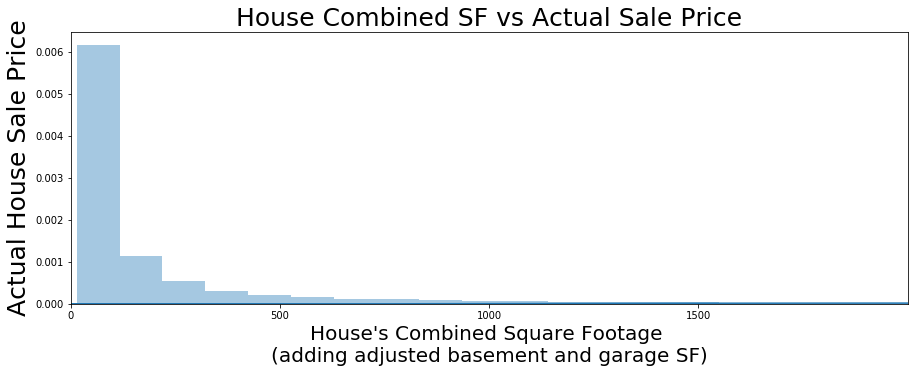

In [89]:
plot = plt.figure(figsize=(15,5))
ax = plot.add_subplot()
sns.distplot(totalwordcounts['wordcount'], bins=1000);

plt.xticks(range(0, 200, 50))
plt.xlim(0,200)
# plt.yticks(.0004)

plt.title('House Combined SF vs Actual Sale Price', fontsize=25);
plt.xlabel('House\'s Combined Square Footage \n(adding adjusted basement and garage SF)', fontsize=20);
plt.ylabel('Actual House Sale Price', fontsize=25);

In [ ]:
# maskhighest = ((Alltrains['Neighborhood']=='NoRidge') | (Alltrains['Neighborhood']=='Somerst') | 
#                (Alltrains['Neighborhood']=='NridgHt') | (Alltrains['Neighborhood']=='StoneBr')
#               )
# facetgrid = sns.lmplot( x="All SF", y="SalePrice", 
#                        data=Alltrains[maskhighest], 
#                        size=7, aspect=2, markers=['x','v',"+",'1'],
#                        fit_reg=False, hue='Neighborhood', legend=False)

# ax = facetgrid.axes[0,0]
# ax.set_ylim(0,650000)
# ax.set_xlim(0,6000)
# plt.title('House Combined SF vs Actual Sale Price', fontsize=25);
# plt.xlabel('House\'s Combined Square Footage \n(adding adjusted basement and garage SF)', fontsize=20);
# plt.ylabel('Actual House Sale Price', fontsize=25);
# plt.legend(loc='center right', fontsize=15)
 
# plt.xticks(fontsize=15);
# plt.yticks(fontsize=15);

# for _, row in Alltrains[maskhighest].iterrows():
#     plt.plot((row['All SF'], row['All SF']), (row['SalePrice'], row['pred4train']),
#              'r-', linewidth=0.5)